# Final Report Notebook

## Tanzania Well Classification
#### Objective 
>Using data from Taarifa and the Tanzanian Ministry of Water, can you predict which pumps are functional, which need some repairs, and which don't work at all? This is an intermediate-level practice competition. Predict one of these three classes based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A smart understanding of which waterpoints will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.  
<p style="text-align:right;"><i>-DRIVENDATA Project Description</i></p>

### Contents
- Notebook Summary
- Library and Data Importing
- EDA
- Data Processing
- Baseline Model
- Multiple Model Iterations
- Draw Conclusions from Final Model
- Business-facing Recommendations

### Notebook Summary

This notebook provides a high level summary of the process we undertook in building the classification model. Our analysis was tailored to provide the Tanzanian Government the ability to predict the status of waterpoint infrastructure. Our reasoning behind this task is to enable the government to prepare for the future water demands in Tanzania. We utilized the [Tanzania Water Well Data](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/) from Driven Data for this analysis, Driven Data provided us with a train_dataset, target_values, and a test_dataset. After generating a [Pandas Profiling Report](../references/well_class_report.html), some insights we aimed to explore were:
- the correlation of the water point regions with the status of the pumps
- management of the water point playing a role in the status of the pumps
- installation by specific engineers or groups playing a role in the status of the pumps

This notebook will walk through the process of data gathering and exploration, how the data was analyzed, our processing methods, and the results of our analysis.

# Initial EDA Insights

### Data Importing

The cell below allows us to import the [functions](https://github.com/sydroth/tanzaniawellclassification/blob/master/src/functions.py) created during our analysis.

In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
from src import mef_test, functions

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from bokeh.plotting import figure, output_file, show
pd.set_option('display.max_columns', 500)
params = {'legend.fontsize': 'large',
         'axes.labelsize': 24,
         'axes.titlesize':24,
         'xtick.labelsize':20,
         'ytick.labelsize':24}
plt.rcParams.update(params)

X_raw = pd.read_csv('../data/train_data.csv', dtype={'id': object})
y_raw = pd.read_csv('../data/train_targets.csv', dtype={'id': object})

# Join the two tables using their 'id' column
df = y_raw.set_index('id').join(X_raw.set_index('id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Rates of functionality differ across regions
Various studies have found that regional and geographic factors play a huge role in well fucntionality. This could be due to proximity to spare part suppliers, the competency of local government maintenance programs, or the strains that geographic restrictions may place on well design. The difference between the region with the most functional wells and the region with the least is significant: 80% of wells in the Iringa region are functioning, compared to 35% of wells in the Lindi region.

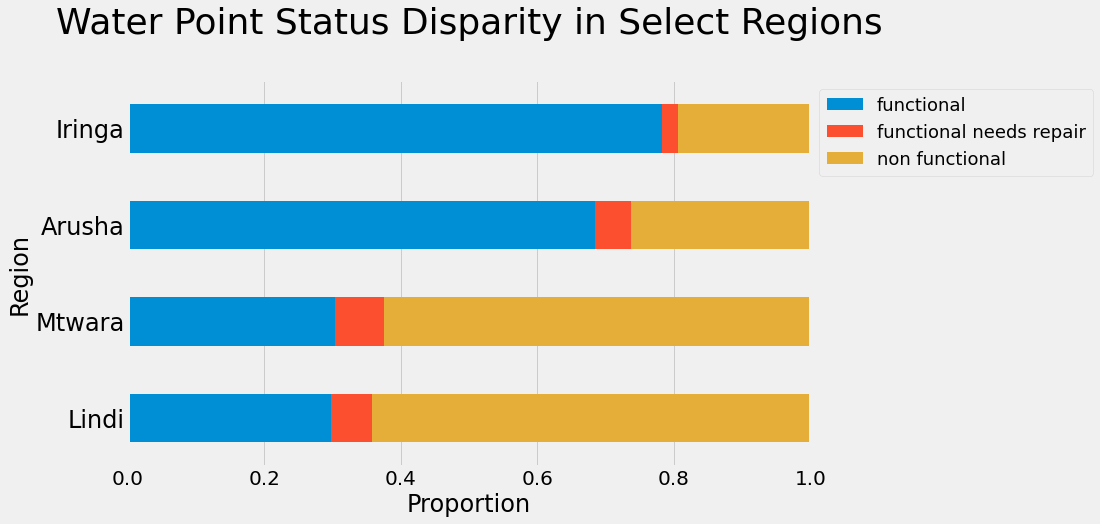

In [4]:
# I think this would be more useful as an unstacked DataFrame
reg = df.groupby('region')['status_group'].value_counts().unstack()

# Making some new columns...i know this is not the most efficient way to do this
reg['pfunc'] = reg['functional'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])
reg['prep'] = reg['functional needs repair'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])
reg['pnon'] = reg['non functional'] / (reg['functional']
                                    + reg['functional needs repair']
                                    + reg['non functional'])

# Going to get just the 2 regions with the highest proportion of functional water points, and then the 2 regions with the lowest
ratios = reg.drop(['functional', 'functional needs repair', 'non functional'], axis=1)
rename = {'pfunc':'functional','prep':'functional needs repair' , 'pnon':'non functional'}
ratios.rename(columns=rename, inplace=True)

sortedx = ratios.sort_values('functional')
extreme = pd.concat([sortedx.head(2), sortedx.tail(2)])

# Now I'll plot these 4 regions as a segmented bar plot

plt.rcParams.update({'font.size': 15})
fig, ax = plt.subplots(figsize=(18,10))
ax.set_title('Water Point Status Disparity in Select Regions\n',
             fontdict={'fontsize':36})

ax.set_xlabel('Proportion')
ax.set_xlim(0,1)
extreme.plot.barh(stacked=True, ax=ax);
ax.set_ylabel('Region',)
ax.legend(fontsize=18, bbox_to_anchor=(1,1));
plt.tight_layout(pad=7)

## Rate of functionality by decade
Naturally We would explore the relationship between the level of functioning wells and how old that well is. In the graph below, we group all wells into 6 decades based on the year they were constructed. Here we see that rate of functionality is higher if it is built more recently.

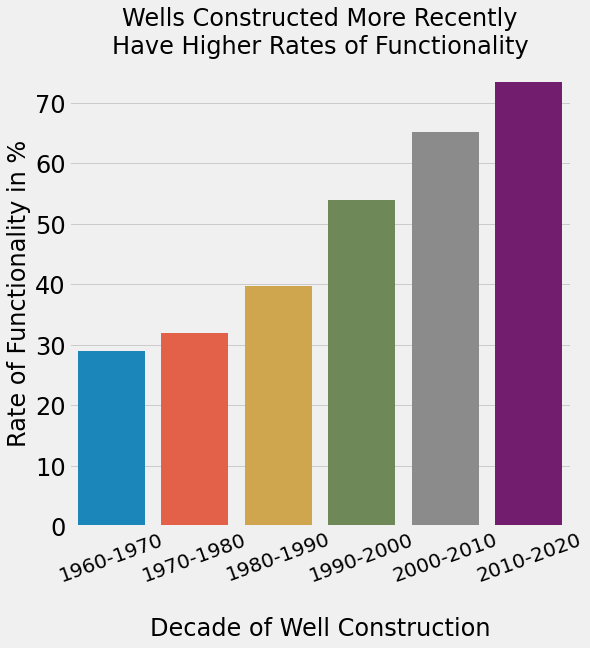

In [5]:
df['outcome_binary'] = mef_test.make_binary(df, 'status_group', 'functional')

no_zeros = df[df['construction_year']!=0].copy()

no_zeros['decade'] = no_zeros['construction_year'].map(functions.bin_year)


functionality_by_year = no_zeros.groupby('decade').outcome_binary.mean()

fig, ax = plt.subplots(1,1, figsize=(8,8))


sns.barplot(functionality_by_year.index, functionality_by_year.values*100)
ax.set_xlabel("\nDecade of Well Construction")
ax.set_ylabel("Rate of Functionality in %")
plt.xticks(rotation=20)


ax.set_title("Wells Constructed More Recently\nHave Higher Rates of Functionality");




## Rate of Functionality differences for Government built wells

Across Tanzania, wells have been installed by a variety of organizations. In addition to government efforts to increase water supply, various NGOs and foreign government agencies have provided assistance in installing well infrastructure. There may be drastic differences between installation quality between these groups. We can find this effect when we look at the distributions of each functionality group and compare it to the rates of fucntionality for all wells. In the graph below, we look at the total functionality rates for all wells across tanzania and we compare it to a subset of wells that we're recorded as having been installed by the government.

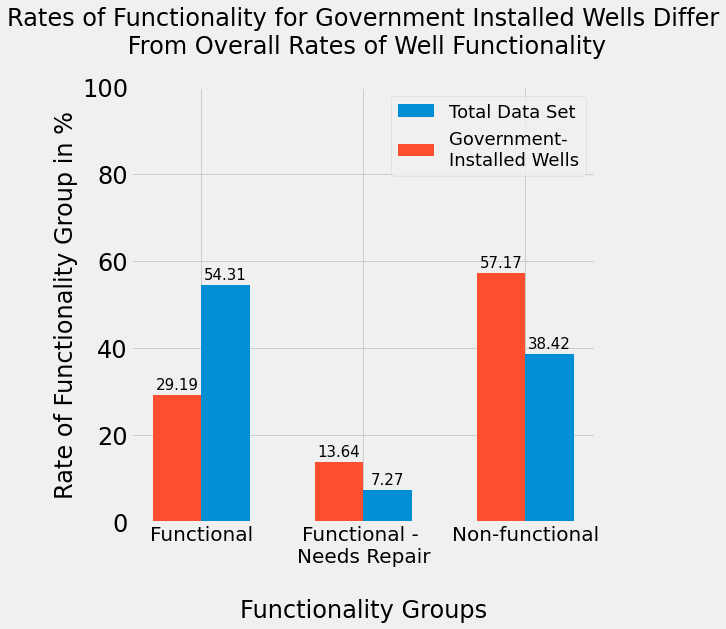

In [6]:
df['installer'] = df['installer'].fillna('unknown')

df['installer'] = df['installer'].map(lambda x: x.lower())

df.installer.value_counts()

dataframe = df
possible_values = list(dataframe['installer'].unique())
column = 'installer'

fig, ax = plt.subplots(1, 1, figsize=(9,9))
labels = ['Functional', 'Functional - \nNeeds Repair', 'Non-functional']
data_set_prcnts = mef_test.calc_prcnts(dataframe)
subset_percents = mef_test.calc_prcnts(dataframe, col_name=column, value='government')

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


rects1 = ax.bar(x + width/2, data_set_prcnts, width, label='Total Data Set', align='center')
rects2 = ax.bar(x - width/2, subset_percents, width, label='Government-\nInstalled Wells', align='center')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('\nFunctionality Groups')
ax.set_ylabel('Rate of Functionality Group in %')
ax.set_title(f'Rates of Functionality for Government Installed Wells Differ\n From Overall Rates of Well Functionality\n')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0,100)


mef_test.autolabel(rects1, ax)
mef_test.autolabel(rects2, ax)


fig.tight_layout()

plt.show();

# Modelling

In [7]:
import src.functions as f

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, mean_squared_error, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, cross_validate
from imblearn.over_sampling import SMOTE, ADASYN
from pandas_profiling import ProfileReport
import datetime

train = f.load_train_add_target_df()

#### We generated a [Pandas Profiling Report](../references/well_class_report.html) for a initial analysis over the dataset.

The cell below shows how variables in the dataset had significa

In [10]:
train.groupby(['quality_group', 'water_quality', 'quality_group']).size()

train.groupby(['extraction_type', 'extraction_type_group', 'extraction_type_class']).size()

train.groupby(['source', 'source_type', 'source_class']).size()

source                source_type           source_class
dam                   dam                   surface           656
hand dtw              borehole              groundwater       874
lake                  river/lake            surface           765
machine dbh           borehole              groundwater     11075
other                 other                 unknown           212
rainwater harvesting  rainwater harvesting  surface          2295
river                 river/lake            surface          9612
shallow well          shallow well          groundwater     16824
spring                spring                groundwater     17021
unknown               other                 unknown            66
dtype: int64

# 

### Class Imbalance
We can see from the plot below that are target variable is not balanced. This may pose a problem when running a classifier algorithm due to the class imbalance and the model not having enough data on the minority class.

              COUNT:
functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64
------------------------------------
              PROPORTION:
functional                 54.308081
non functional             38.424242
functional needs repair     7.267677
Name: status_group, dtype: float64


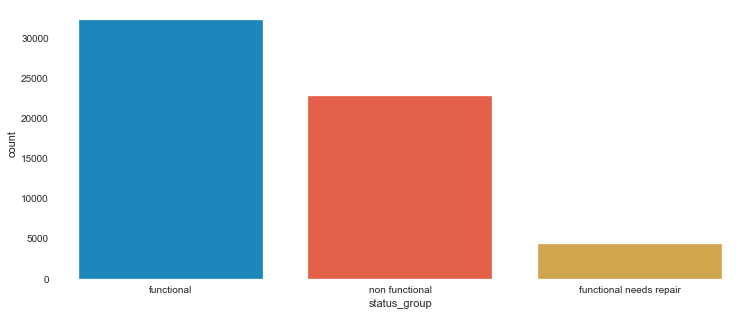

In [11]:
plt.figure(figsize=(11,5))
sns.countplot(train.status_group)
print('              COUNT:')

print(train.status_group.value_counts())
print('------------------------------------')
print('              PROPORTION:')
print(train.status_group.value_counts(normalize=True)*100)

### Model Success Criteria

In order for our model to be effective, we will be seeking to minimize false negatives. A false negative in context to our model would be identifying a water point as functional when it is in fact non-functional. This poses an issue in the sense that we wouldn't want to falsely classify a water point as functional when it is not and possibly leaving people without water.

## Baseline Model

For our baseline model we chose to utilize a Decision Tree Classifier with default parameters. We chose to use management and payment as the two predictor variables and status as the target. For management we filled the na values by subtracting the values classified as 'school' from the values classified as 'other' for a combined feature 'other'. If the value was classified as 'water authority' it was also classified as 'other'.

In [13]:
#adding status to training dataframe
train['status'] = train.status_group.replace(f.numeric_status_group())
#defining x and y for model
X = train[['management', 'payment']]
y = train.status
#Binning management values
X['management'] = X['management'].fillna('unknown')
categories = {'other - school': 'other',
             'company': 'private operator',
             'unknown': 'other',
             'trust': 'other',
             'water authority': 'other'
             }
X['management'] = X['management'].replace(categories)
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
#defining features to encode
ohe_features = ['management', 'payment']
#instantiating OneHotEncoder with drop parameter set to first
ohe = OneHotEncoder(drop='first')
#assigning categoriacal features to pandas series
X_train_cat = X_train[ohe_features]
#fit transforming encoder to training split and transforming testing split
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_cat = X_test[ohe_features]
X_test_ohe = ohe.transform(X_test_cat)
columns_test = ohe.get_feature_names(input_features=X_test_cat.columns)
X_test_processed = pd.DataFrame(X_test_ohe.todense(), columns=columns_test)
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
X_train_processed = pd.DataFrame(X_train_ohe.todense(), columns=columns)

#Instantiating decision tree classifier with a max depth of 5
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train_processed, y_train)
#predicting on test split
y_pred = dt.predict(X_test_processed)
print(classification_report(y_test, y_pred, zero_division=0))
#Validating on test split with cross val score
cvs = cross_val_score(dt, X_test_processed, y_test, cv=5)
print('Mean Cross Val Score:',np.mean(cvs))

              precision    recall  f1-score   support

           0       0.52      0.59      0.55      5678
           1       0.00      0.00      0.00      1074
           2       0.64      0.67      0.66      8098

    accuracy                           0.59     14850
   macro avg       0.39      0.42      0.40     14850
weighted avg       0.55      0.59      0.57     14850

Mean Cross Val Score: 0.591986531986532


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [14]:
confusion_matrix(y_test, y_pred)

array([[3344,    0, 2334],
       [ 393,    0,  681],
       [2651,    0, 5447]])

This model is not classifying class 1 at all due to the class imbalance. This model returned a mean cross val score of 59 percent leaving us plenty of room for improvement.

## Model Iterations

##### The following cell is importing our training [processed data](https://github.com/sydroth/tanzaniawellclassification/blob/master/src/functions.py), scaling numerical features and encoding categorical features.
##### The processing steps for processed data can be found 

In [15]:
train = pd.read_csv('../data/processed_data.csv')
train.permit = train.permit.astype(str)

##### Defining predictor variables(X) and target variable(y), performing train test split

In [16]:
X = train.drop(['id', 'status_group', 'status', 'date_recorded'], axis=1)
y = train.status
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

##### Defining features to encode with OneHotEncoder

In [17]:
ohe_features = ['funder/installer', 'region_bins',
               'public_meeting', 'lga_coded',
               'scheme_management/management', 'permit', 
               'extraction_type/group/class', 
               'payment', 'quality_group',
               'quantity', 'source_type', 'waterpoint_type/group']

##### Defining continuous numerical features to scale with StandardScaler as well as the engineered binned decade features

In [18]:
cont_features = ['gps_height', 'population'
                 ]

decade_features = ['2000-2010', '1990-2000', '1980-1990',
                   '2010-2020', '1970-1980', '1960-1970']

##### Assigning the categorical and continuous features to a series in order to fit the encoder and scaler 

In [19]:
X_train_ohe = X_train[ohe_features]
X_test_ohe = X_test[ohe_features]
X_train_cont = X_train[cont_features].astype(float)
X_test_cont = X_test[cont_features].astype(float)

##### Saving the index for both dataframes and casting the continous values as float types

In [20]:
X_train_index = X_train.index
X_test_index = X_test.index

##### Instantiating encoder and scaler, then fit transforming on the train data and transforming the test data. Creating dataframes with the numerical features for concatenation

In [21]:
ohe = OneHotEncoder()
ss = StandardScaler()
X_train_encoded = ohe.fit_transform(X_train_ohe)
X_test_encoded = ohe.transform(X_test_ohe)
X_train_scaled = pd.DataFrame(ss.fit_transform(X_train_cont), columns=X_train[cont_features].columns, index=X_train_index)
X_test_scaled = pd.DataFrame(ss.transform(X_test_cont), columns=X_test[cont_features].columns, index=X_test_index)

##### Retrieving feature names and creating dataframes assigned to X_train_processed and X_test_processed with the one hot encoded features

In [22]:
train_columns = ohe.get_feature_names(input_features=X_train_ohe.columns)
test_columns = ohe.get_feature_names(input_features=X_test_ohe.columns)
X_train_processed = pd.DataFrame(X_train_encoded.todense(), columns=train_columns, index=X_train_index)
X_test_processed = pd.DataFrame(X_test_encoded.todense(), columns=test_columns, index=X_test_index)

##### Concatenating processed numerical and categorical dataframes 

In [23]:
X_train_all = pd.concat([X_train_scaled, X_train_processed], axis=1)
X_test_all = pd.concat([X_test_scaled, X_test_processed], axis=1)

##### Joining the binned decade features to the X_train_all dataframe

In [24]:
X_train_all = X_train_all.join(X_train[decade_features])
X_test_all = X_test_all.join(X_test[decade_features])

#### For the second model iteration we chose to go back to a Decision Tree Classifier with processed features

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train_all, y_train)
y_hat_val = dt.predict(X_test_all)
f.evaluation(y_test, dt.predict(X_test_all))

This was an improvement from our baseline model but is still significantly overfit and the recall score is lower than we'd like it to be at .65

#### For the third iteration we chose a Random Forest Classifier n_estimators parameter set to 500

In [ ]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train_all, y_train)
f.evaluation(y_test, rf.predict(X_test_all))

This model was a small improvement from the decision tree classifier but still running into the same problem of class imbalance

#### Our final model iteration was a Random Forest Classifier with the optimal parameters from a grid search cv. This model was fitted to a smote resampled x and y and scored on the original x and y that were not resampled.

#### SMOTE oversampling the minority class
Returning to the processed dataset again so I can perform smote oversampling on the minority class and then train test split the data. Performing the same encoding and scaling steps as above but on the entire train dataset before the train test split

In [ ]:
train_ohe = train[ohe_features]
train_cont = train[cont_features].astype(float)
train_index = train.index

ohe2 = OneHotEncoder()
ss2 = StandardScaler()
train_encoded = ohe2.fit_transform(train_ohe)
train_scaled = pd.DataFrame(ss2.fit_transform(train_cont), columns=train[cont_features].columns, index=train_index)
train_columns = ohe2.get_feature_names(input_features=train_ohe.columns)
train_processed = pd.DataFrame(train_encoded.todense(), columns=train_columns, index=train_index)
train_all = pd.concat([train_scaled, train_processed], axis=1)
train_all = train_all.join(train[decade_features])
train_all['status'] = train['status']

In [ ]:
X_smote = train_all.drop(['status'], axis=1)
y_smote = train_all.status
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_res, y_res = smote.fit_sample(X_smote, y_smote)

### Optimal Random Forest Parameters
#### n_estimators = 1500
#### max_depth = 25
#### min_samples_split = 8
#### class_weight = balanced subsample

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_res, y_res, random_state=42)

final_model = RandomForestClassifier(random_state=42, max_depth=25, min_samples_split=8,
                             n_jobs= -1, n_estimators=1500, class_weight='balanced_subsample')
start_time = f.timer(None)
final_model.fit(X_t, y_t)
y_pred = final_model.predict(X_val)
print('Train evaluation:')
print(f.evaluation(y_val, y_pred))
f.timer(start_time)
print('Test evaluation')
print(f.evaluation(y_test, final_model.predict(X_test_all)))

#### After resampling with smote and scoring on the processed test split, we were able to achieve a testing recall score of 82 percent. Out of all of the water points classified as non-functional, our model was able to predict 82 percent of them as non-functional. This final model had an accuracy of 82 percent

## Business-Facing Recommendations
#### Having completed this project something we would like to explore for more insight to the project would be:
- More data to analyze the current waterpoint usage and observe the longevity of water point pumps
#### Funding
- Increase funding for regions with more non-functional water points by subsidizing either private or community built water points
#### Community Involvement
- Include the community in the planning and building process of new water points to improve the overall care and longevity.